In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Cargar el dataset
df = pd.read_csv('visitas-residentes-y-no-residentes.csv')
df

,indice_tiempo,origen_visitantes,visitas,observaciones
0,2008-01-01,no residentes,198407,NaN
1,2008-01-01,residentes,352303,NaN
2,2008-01-01,total,550710,NaN
3,2008-02-01,no residentes,151809,NaN
4,2008-02-01,residentes,283145,NaN
...,...,...,...,...
580,2024-02-01,residentes,229374,NaN
581,2024-02-01,total,414809,NaN
582,2024-03-01,no residentes,166021,NaN
583,2024-03-01,residentes,192938,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585 entries, 0 to 584
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   indice_tiempo      585 non-null    object
 1   origen_visitantes  585 non-null    object
 2   visitas            585 non-null    int64 
 3   observaciones      132 non-null    object
dtypes: int64(1), object(3)
memory usage: 18.4+ KB


# Procedemos a limpiar los datos, extrayendo los referidos a la epoca de pandemia ya que los trataremos a parte.

In [4]:
# 2. Limpieza de datos: Eliminar la columna observaciones

df.drop('observaciones', axis=1, inplace=True)
df

,indice_tiempo,origen_visitantes,visitas
0,2008-01-01,no residentes,198407
1,2008-01-01,residentes,352303
2,2008-01-01,total,550710
3,2008-02-01,no residentes,151809
4,2008-02-01,residentes,283145
...,...,...,...
580,2024-02-01,residentes,229374
581,2024-02-01,total,414809
582,2024-03-01,no residentes,166021
583,2024-03-01,residentes,192938


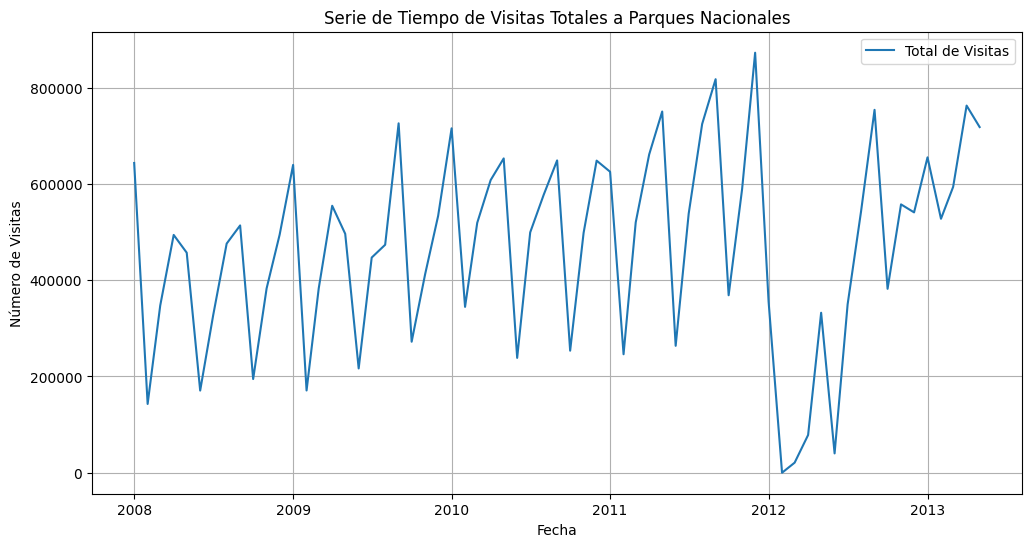

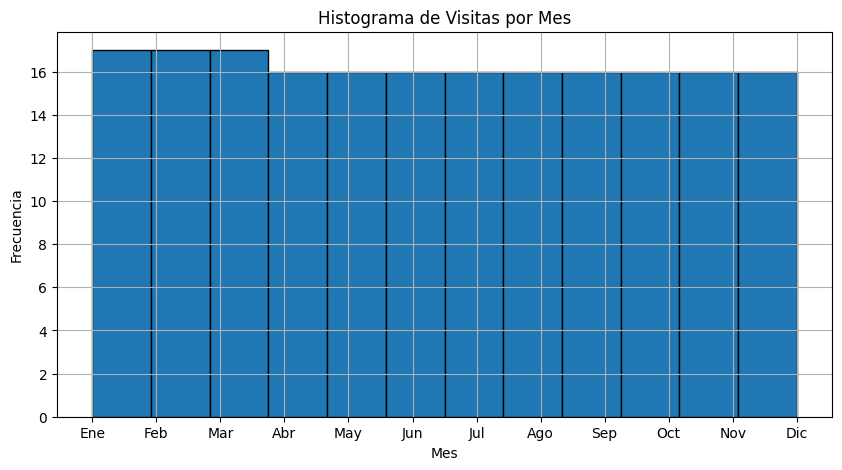

In [5]:
# 3. Transformación de datos
# Crear columna "total_visitas"
df['total_visitas'] = df['visitas'].groupby(df.index // 3).sum()

# Convertir 'indice_tiempo' a datetime y extraer características
df['indice_tiempo'] = pd.to_datetime(df['indice_tiempo'])
df['año'] = df['indice_tiempo'].dt.year
df['mes'] = df['indice_tiempo'].dt.month
df['dia_semana'] = df['indice_tiempo'].dt.dayofweek  # 0: Lunes, 6: Domingo

# Eliminar las filas duplicadas por fecha
df = df[df['origen_visitantes'] == 'total']

# 4. Visualización de datos
# Serie de tiempo de visitas totales
plt.figure(figsize=(12, 6))
plt.plot(df['indice_tiempo'], df['total_visitas'], label='Total de Visitas')
plt.xlabel('Fecha')
plt.ylabel('Número de Visitas')
plt.title('Serie de Tiempo de Visitas Totales a Parques Nacionales')
plt.legend()
plt.grid(True)
plt.show()

# Histograma de visitas por mes
plt.figure(figsize=(10, 5))
plt.hist(df['mes'], bins=12, edgecolor='black')
plt.xlabel('Mes')
plt.ylabel('Frecuencia')
plt.title('Histograma de Visitas por Mes')
plt.xticks(range(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.grid(True)
plt.show()


 Se observa una clara estacionalidad en los datos de visitas a los parques nacionales. Hay un patrón que se repite cada año:
Picos de visitas: En los meses de verano (diciembre, enero, febrero) las visitas se disparan.
Bajas de visitas: Durante los meses de invierno (junio, julio, agosto) las visitas disminuyen considerablemente.
Este comportamiento es completamente lógico si consideramos que las condiciones climáticas son un factor determinante para visitar un parque nacional.

# Modelo de Machine Learning

Vanos a plantear la creación de un modelo de aprendizaje automatico que sea capaz de ver más allá de esa estacionalidad y predecir de forma eficiente las visitas futuras a parques nacionales.

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Selecciona las columnas que deseas escalar
features = ['total_visitas'] # Puedes agregar más columnas si lo deseas

# Crea una instancia de StandardScaler
scaler = StandardScaler()

# Ajusta el escalador a las columnas seleccionadas
scaler.fit(df[features])

# Transforma las columnas usando el escalador
df[features] = scaler.transform(df[features])


<ipython-input-6-a72beacac50b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[features] = scaler.transform(df[features])


In [7]:
# 4. Ingeniería de características

# 4.1. Variables dummy para meses
df = pd.get_dummies(df, columns=['mes'], prefix='mes')


Ahora elaboramos el modelo de ML con una arquitectura XGBoost que se adapta muy bien para modelar datos de series de tiempo.

MAE: 0.73
RMSE: 0.88


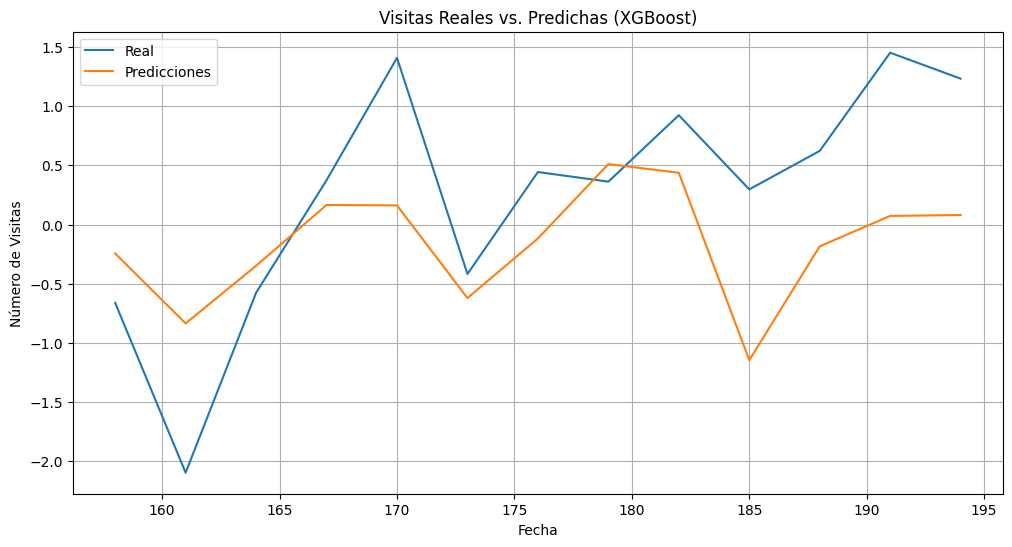

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 4.2. Crear variables lagged (retrasadas)
# Ejemplo: Crear variables para las visitas de los últimos 3 meses
for i in range(1, 4):
    df[f'visitas_lag_{i}'] = df['total_visitas'].shift(i).fillna(method='bfill')

# 4.3. Eliminar filas con valores NaN (debido a las variables lagged)
df.dropna(inplace=True)

# 5. Preparar datos para XGBoost
# 5.1. Seleccionar características (X) y variable objetivo (y)
features = ['año', 'dia_semana'] + list(df.columns[df.columns.str.startswith('mes_')]) + list(df.columns[df.columns.str.startswith('visitas_lag_')])
X = df[features]
y = df['total_visitas']

# 5.2. Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_test = scaler.transform(X_test)

# 7. Crear y entrenar el modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror',
                          n_estimators=100, # Ajusta estos hiperparámetros
                          learning_rate=0.1,
                          max_depth=3)
model.fit(X_train, y_train)

# 8. Realizar predicciones
y_pred = model.predict(X_test)

# 9. Evaluar el modelo
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# 10. Visualizar predicciones vs valores reales
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Real')
plt.plot(y_test.index, y_pred, label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Número de Visitas')
plt.title('Visitas Reales vs. Predichas (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()

De acuerdo a las metricas consideradas, el modelo funciona razonablemente bien para predecir nuevas visitas a los parques nacionales